<a href="https://colab.research.google.com/github/Indrani934/Blockchain-Security-Audits/blob/main/parkinson's.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import zipfile

In [2]:
def mount_google_drive():
    from google.colab import drive
    drive.mount("/content/drive")

In [3]:
def set_kaggle_configuration():
    os.makedirs('/root/.kaggle', exist_ok=True)
    os.chmod('/content/kaggle.json', 0o600)
    !kaggle datasets download kmader/parkinsons-drawings

In [4]:
def extract_zip(zip_file_path, extract_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Zip file extracted to: {extract_path}")

In [5]:
def collect_image_data(directory):
    return [
        [os.path.join(root, file), root.split(os.sep)[-1]]
        for root, dirs, files in os.walk(directory)
        for file in files if file.endswith(('.png', '.jpg'))
    ]

In [6]:
def load_and_prepare_data(directory):
    data = collect_image_data(directory)
    df = pd.DataFrame(data, columns=['file_path', 'label'])
    return df

In [7]:
def plot_label_distribution(df):
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x='label', palette='viridis')
    plt.title("Count of Each Label")
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.show()

    plt.figure(figsize=(8, 8))
    df['label'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140, colors=['#66c2a5', '#fc8d62'])
    plt.title("Label Distribution")
    plt.ylabel("")
    plt.show()

In [8]:
def display_sample_images(df, labels, n_samples=5):
    fig, axes = plt.subplots(len(labels), n_samples, figsize=(15, 6))
    for i, label in enumerate(labels):
        for j in range(n_samples):
            img_path = df[df['label'] == label].iloc[j]['file_path']
            img = Image.open(img_path)
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].set_title(label)
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/kmader/parkinsons-drawings
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
 89% 37.0M/41.4M [00:00<00:00, 124MB/s]
100% 41.4M/41.4M [00:00<00:00, 129MB/s]
Zip file extracted to: /content/parkinsons-drawings
                                           file_path    label
0  /content/parkinsons-drawings/spiral/training/h...  healthy
1  /content/parkinsons-drawings/spiral/training/h...  healthy
2  /content/parkinsons-drawings/spiral/training/h...  healthy
3  /content/parkinsons-drawings/spiral/training/h...  healthy
4  /content/parkinsons-drawings/spiral/training/h...  healthy
                                            file_path      label
67  /content/parkinsons-drawings/spiral/training/p...  parkinson
68  /content/parkinsons-drawings/spiral/training/p...  parkinson
69  /content/parkinsons-drawings/spiral/training/p...  parkinson
70  /content/parkinsons-drawings/spiral/training/p

<ipython-input-7-a3618ed0b0e1>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='label', palette='viridis')


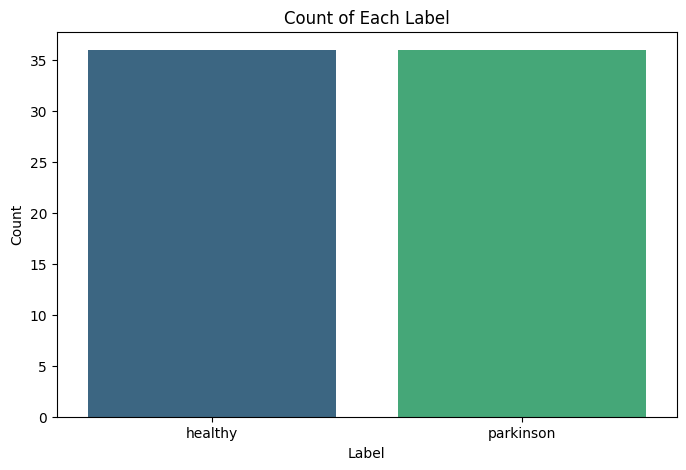

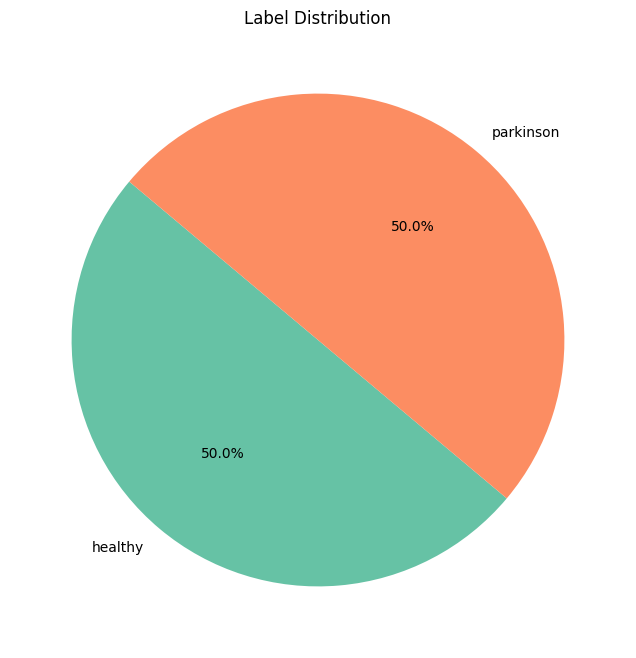

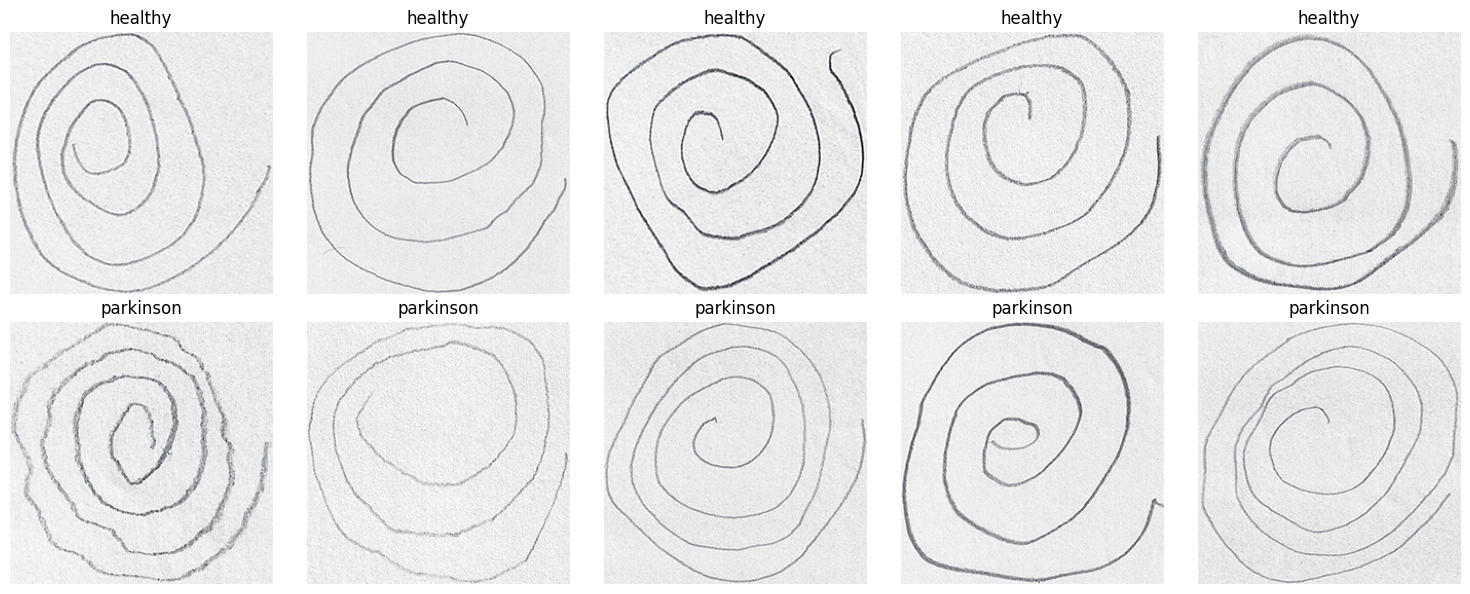

In [9]:
if __name__ == "__main__":
    mount_google_drive()
    set_kaggle_configuration()
    extract_zip('/content/parkinsons-drawings.zip', '/content/parkinsons-drawings')

    df = load_and_prepare_data('/content/parkinsons-drawings/spiral/training')
    print(df.head())
    print(df.tail())
    print(df.shape)
    print(df.info())
    print(df.nunique())

    plot_label_distribution(df)
    display_sample_images(df, ['healthy', 'parkinson'])

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def create_augmented_datagen():
    return ImageDataGenerator(
        rescale=1./255,
        rotation_range=45,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )
def create_rescale_datagen():
    return ImageDataGenerator(rescale=1./255)
def create_flow_from_dataframe(datagen, dataframe, target_size=(224, 224), batch_size=16, class_mode='binary', shuffle=True):
    return datagen.flow_from_dataframe(
        dataframe,
        x_col='file_path',
        y_col='label',
        target_size=target_size,
        class_mode=class_mode,
        color_mode='rgb',
        batch_size=batch_size,
        shuffle=shuffle
    )

In [12]:
def split_data(df):
    train_df, temp_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=42, stratify=df['label'])
    test_df, valid_df = train_test_split(temp_df, test_size=0.333, shuffle=True, random_state=42, stratify=temp_df['label'])
    return train_df, test_df, valid_df

In [13]:
train_df, test_df, valid_df = split_data(df)

In [14]:
train_datagen = create_augmented_datagen()
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='binary',
    color_mode='rgb',
    batch_size=16,
    shuffle=True
)

Found 50 validated image filenames belonging to 2 classes.


Found 50 validated image filenames belonging to 2 classes.


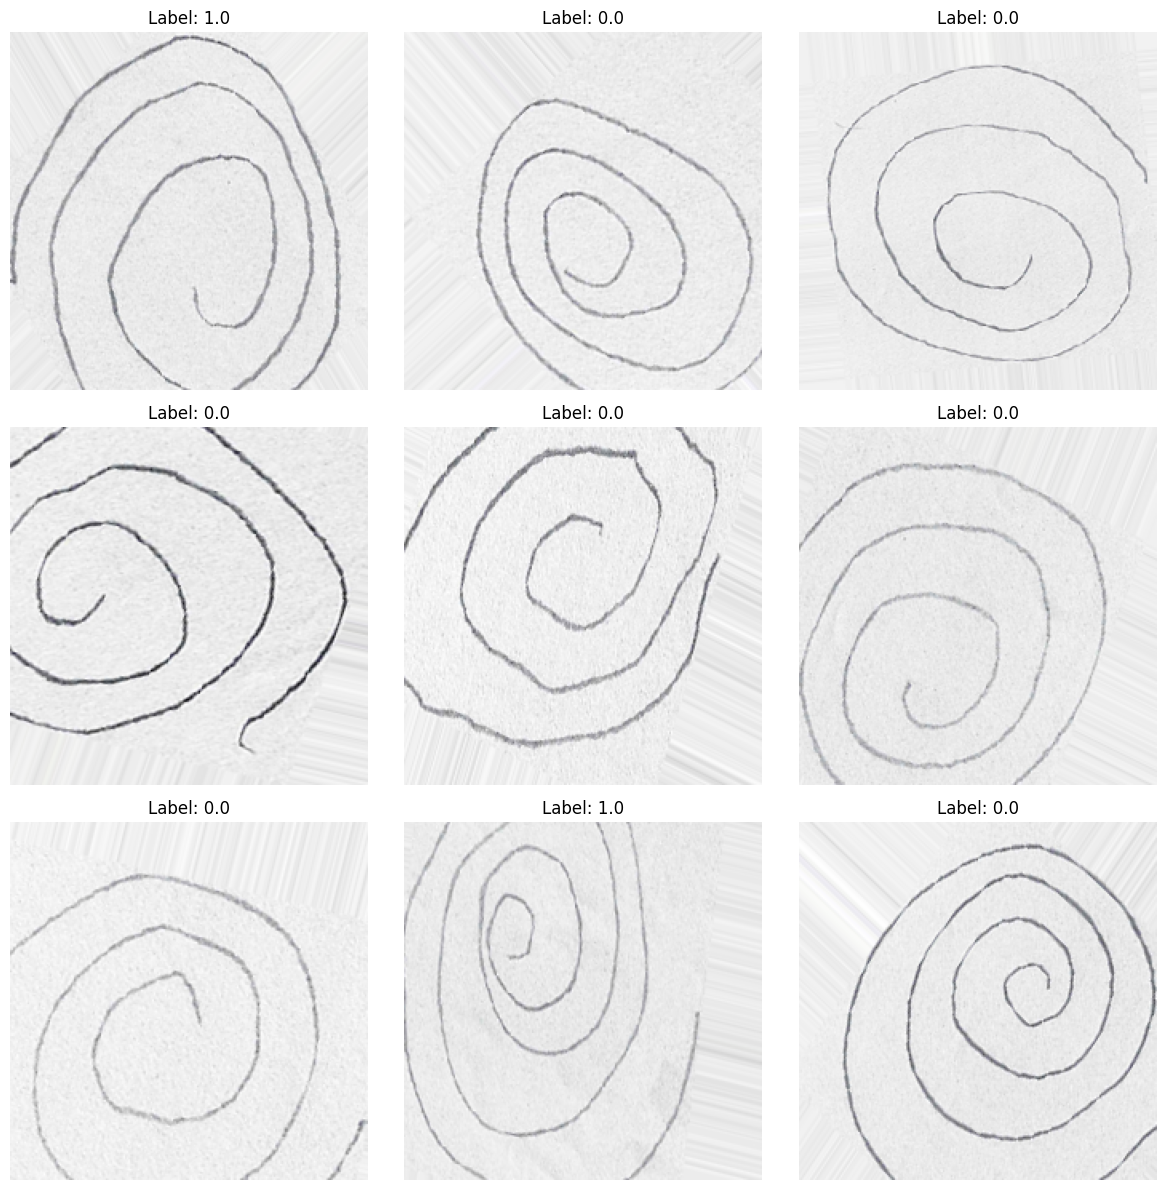

In [15]:
def plot_examples(data_gen):
    """Function to plot examples of data augmentation."""
    plt.figure(figsize=(12, 12))
    for i, (images, labels) in enumerate(data_gen):
        for j in range(9):
            plt.subplot(3, 3, j + 1)
            image = images[j]
            if image.shape[2] == 1:
                plt.imshow(image[:, :, 0], cmap='gray')
            else:  # If RGB
                plt.imshow(image)
            plt.title(f'Label: {labels[j]}')
            plt.axis('off')
        break
    plt.tight_layout()
    plt.show()

train_gen = create_flow_from_dataframe(train_datagen, train_df, batch_size=9)
plot_examples(train_gen)

In [16]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [17]:
import seaborn as sns

def evaluate_model(model, test_gen):
    test_loss, test_acc = model.evaluate(test_gen)
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")
    predictions = (model.predict(test_gen) > 0.5).astype(int)
    y_true = test_gen.classes
    conf_matrix = confusion_matrix(y_true, predictions)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Parkinson'], yticklabels=['Healthy', 'Parkinson'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    print("\nClassification Report:")
    print(classification_report(y_true, predictions, target_names=test_gen.class_indices.keys()))

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint
def get_callbacks(model_name):
    return [ModelCheckpoint(filepath=f"{model_name}_best_model.keras", monitor='val_accuracy', save_best_only=True, verbose=1)]

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
def build_improved_model():
    model = Sequential([
        Input(shape=(224, 224, 3)),

        # Block 1
        Conv2D(32, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2), strides=(2, 2)),
        # Block 2
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2), strides=(2, 2)),
        # Block 3
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2), strides=(2, 2)),
        # Block 4
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2), strides=(2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model


Found 50 validated image filenames belonging to 2 classes.
Found 14 validated image filenames belonging to 2 classes.
Found 8 validated image filenames belonging to 2 classes.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      25,690,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,342,209 (100.49 MB)

 Trainable params: 26,342,209 (100.49 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4592 - loss: 0.7684
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to improvedcnn_best_model.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.4594 - loss: 0.7725 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7612 - loss: 0.6486
Epoch 2: val_accuracy did not improve from 0.50000
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.7330 - loss: 0.6573 - val_accuracy: 0.5000 - val_loss: 0.6939
Epoch 3/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5245 - loss: 0.6891
Epoch 3: val_accuracy did not improve from 0.50000
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5156 - loss: 0.6938 - val_accuracy: 0.5000 - val_loss: 0.6942
Epoch 4/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3028 - loss: 0.7177
Epoch 4: val_accuracy did not improve from 0.50000
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.3143 - loss: 0.7158 - val_accuracy: 0.5000 - val

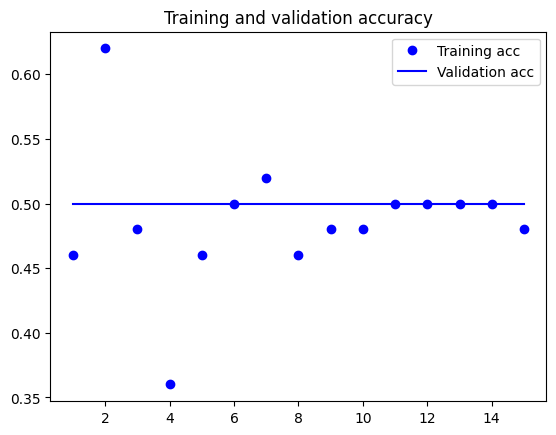

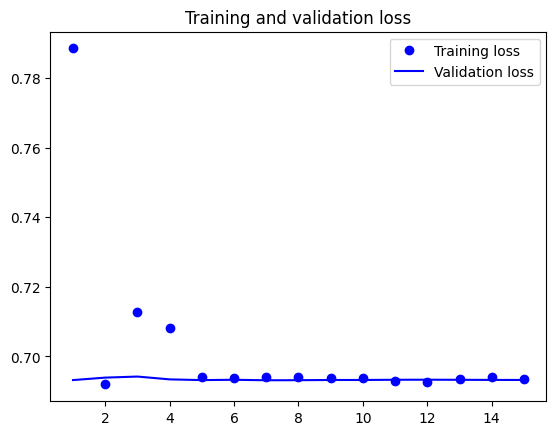

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step - accuracy: 0.5000 - loss: 0.6935
Test Accuracy: 50.00%
Test Loss: 0.6935
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step


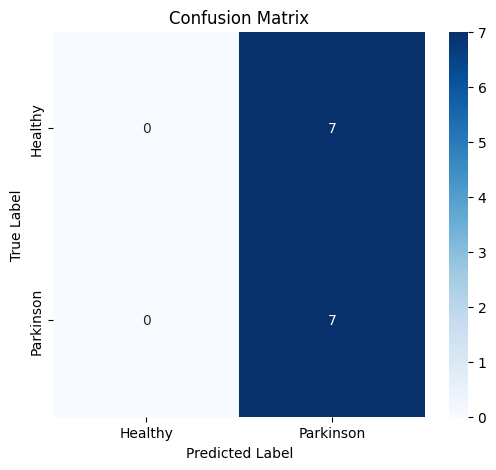


Classification Report:
              precision    recall  f1-score   support

     healthy       0.00      0.00      0.00         7
   parkinson       0.50      1.00      0.67         7

    accuracy                           0.50        14
   macro avg       0.25      0.50      0.33        14
weighted avg       0.25      0.50      0.33        14



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
if __name__ == "__main__":
    train_df, test_df, valid_df = split_data(df)
    train_datagen = create_augmented_datagen()
    test_valid_datagen = create_rescale_datagen()
    train_gen = create_flow_from_dataframe(train_datagen, train_df)
    test_gen = create_flow_from_dataframe(test_valid_datagen, test_df, shuffle=False)
    valid_gen = create_flow_from_dataframe(test_valid_datagen, valid_df)

    model1 = build_improved_model()
    callbacks = get_callbacks("improvedcnn")
    history1 = model1.fit(train_gen, validation_data=valid_gen, epochs=15, callbacks=callbacks)
    plot_training_history(history1)

    model1.load_weights("improvedcnn_best_model.keras")
    evaluate_model(model1, test_gen)

In [21]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam

def build_vgg16_improved_model(input_shape=(224, 224, 3)):
    base_model = VGG16(include_top=False, weights='imagenet', input_tensor=Input(shape=input_shape))
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model
model = build_vgg16_improved_model()
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,138,753 (80.64 MB)

 Trainable params: 6,423,553 (24.50 MB)

 Non-trainable params: 14,715,200 (56.13 MB)

In [ ]:
if __name__ == "__main__":
    train_df, test_df, valid_df = split_data(df)
    train_datagen = create_augmented_datagen()
    test_valid_datagen = create_rescale_datagen()
    train_gen = create_flow_from_dataframe(train_datagen, train_df)
    test_gen = create_flow_from_dataframe(test_valid_datagen, test_df, shuffle=False)
    valid_gen = create_flow_from_dataframe(test_valid_datagen, valid_df)

    model2 = build_vgg16_improved_model()
    callbacks = get_callbacks("vgg16")
    history2 = model2.fit(train_gen, validation_data=valid_gen, epochs=15, callbacks=callbacks)
    plot_training_history(history2)

    model2.load_weights("vgg16_best_model.keras")
    evaluate_model(model2, test_gen)

Found 50 validated image filenames belonging to 2 classes.
Found 14 validated image filenames belonging to 2 classes.
Found 8 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.4247 - loss: 1.0078
Epoch 1: val_accuracy improved from -inf to 0.87500, saving model to vgg16_best_model.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 35s 10s/step - accuracy: 0.4678 - loss: 0.9802 - val_accuracy: 0.8750 - val_loss: 0.5192
Epoch 2/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7885 - loss: 0.5220
Epoch 2: val_accuracy did not improve from 0.87500
4/4 ━━━━━━━━━━━━━━━━━━━━ 32s 7s/step - accuracy: 0.7908 - loss: 0.5127 - val_accuracy: 0.7500 - val_loss: 0.4993
Epoch 3/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8304 - loss: 0.4559
Epoch 3: val_accuracy did not improve from 0.87500
4/4 ━━━━━━━━━━━━━━━━━━━━ 32s 7s/step - accuracy: 0.8323 - loss: 0.4492 - val_accuracy: 0.8750 - val_loss: 0.4592
Epoch 4/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7373 - loss: 0.5769
Epoch 4: val_accuracy did not improve from 0.87500
4/4 ━━━━━━━━━━━━━━━━━━━━ 32s 7s/step - accuracy: 0.7338 - loss: 0.6054 - val_accuracy: 0.8750 - val_lo

In [ ]:
from tensorflow.keras.models import load_model
improved_cnn_model = load_model("improvedcnn_best_model.keras")
vgg16_model = load_model("vgg16_best_model.keras")

In [ ]:
test_steps = len(test_df) // test_gen.batch_size
if len(test_df) % test_gen.batch_size != 0:
    test_steps += 1

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report

def evaluate_and_get_metrics(model, test_gen, steps):
    test_gen.reset()
    predictions = model.predict(test_gen, steps=steps)
    predictions = (predictions > 0.5).astype(int).flatten()
    y_true = test_gen.classes

    accuracy = accuracy_score(y_true, predictions)
    report = classification_report(y_true, predictions, target_names=['healthy', 'parkinson'], output_dict=True)

    metrics = {
        "Accuracy": accuracy,
        "Precision": report['parkinson']['precision'],
        "Recall": report['parkinson']['recall'],
        "F1-Score": report['parkinson']['f1-score']
    }
    return metrics
improved_cnn_metrics = evaluate_and_get_metrics(improved_cnn_model, test_gen, steps=test_steps)
vgg16_metrics = evaluate_and_get_metrics(vgg16_model, test_gen, steps=test_steps)
metrics_data = {
    "Improved CNN": improved_cnn_metrics,
    "VGG16": vgg16_metrics
}
metrics_df = pd.DataFrame(metrics_data).T

# Display the DataFrame
print(metrics_df)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
fig.suptitle('Comparison of Model Performance Metrics')
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for ax, metric in zip(axes.flatten(), metrics):
    metrics_df[metric].plot(kind="bar", ax=ax, color=['skyblue', 'lightgreen'])
    ax.set_title(metric)
    ax.set_ylabel('Scores')
    ax.set_xticklabels(metrics_df.index, rotation=0)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
def predict_image(model, image_path, target_size):
    img = load_img(image_path, target_size=target_size, color_mode='rgb')
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    predicted_class = 'parkinson' if prediction[0, 0] > 0.4 else 'healthy'
    return predicted_class, prediction[0, 0], img

model_path = "vgg16_best_model.keras"
model = load_model(model_path)

image_path = "/content/V01PO01.png"

predicted_class, prediction_probability, img = predict_image(model, image_path, target_size=(224, 224))

plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title(f'Predicted: {predicted_class}, Probability: {prediction_probability:.2f}')
plt.axis('off')
plt.show()
